In [ ]:
import logging
from pathlib import Path

import joblib
from matplotlib import pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

from src.config import ConfigManager
from src.database import (
    get_dic_analysis_ids,
    get_dic_data,
    get_image,
)
from src.gmm import (
    plot_gmm_clusters,
    plot_gmm_log_likelihood_contours,
)
from src.preprocessing import apply_dic_filters, preproc_features
from src.roi import PolygonROISelector, filter_dataframe
from src.visualization import plot_dic_vectors

%matplotlib widget

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)

# Load configuration
config = ConfigManager()

# Create the connection to the database
db_engine = create_engine(config.db_url)

# Parameters data selection and output
# camera_names = ["PPCX_Tele", "PPCX_Wide"] # Use only one camera for testing
camera_names = config.get("clustering.variables_names")
target_date = "2024-09-02"
camera_name = "PPCX_Tele"
base_output_dir = "output"

In [34]:
# Build the output folder and base_name
output_dir = Path(base_output_dir) / camera_name
output_dir.mkdir(parents=True, exist_ok=True)
base_name = f"{camera_name}_{target_date}_GMM"

# Get DIC analysis metadata (filtered by date/camera)
dic_analyses = get_dic_analysis_ids(
    db_engine, reference_date=target_date, camera_name=camera_name
)
dic_analyses

,dic_id,camera_name,master_timestamp,slave_timestamp,master_image_id,slave_image_id,dt_hours
0,639,PPCX_Tele,2024-08-27 07:03:35+00:00,2024-09-02 07:03:33+00:00,34993,35072,144


In [35]:
# Get the master image for the DIC analysis via the API
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(master_image_id, camera_name=camera_name)

In [47]:
# Fetch the displacement data for that DIC analysis via the API
dic_id = dic_analyses["dic_id"].iloc[0]
df = get_dic_data(
    dic_id,
    app_host=config.get("api.host"),
    app_port=config.get("api.port"),
)

df = apply_dic_filters(
    df,
    filter_outliers=config.get("dic.filter_outliers"),
    tails_percentile=config.get("dic.tails_percentile"),
    min_velocity=config.get("dic.min_velocity"),
    apply_2d_median=config.get("dic.apply_2d_median"),
    median_window_size=config.get("dic.median_window_size"),
    median_threshold_factor=config.get("dic.median_threshold_factor"),
)

2025-07-28 17:02:37,333 - INFO - Starting DIC filtering pipeline with 5251 points
2025-07-28 17:02:37,339 - INFO - Percentile filtering: 5251 -> 5146 points (removed 105 outliers)
2025-07-28 17:02:37,342 - INFO - Min velocity filtering: 5146 -> 3709 points (removed 1437 points below 1)
2025-07-28 17:02:37,343 - INFO - Applying 2D median filter: window_size=5, threshold_factor=3.0
2025-07-28 17:02:37,350 - INFO - Estimated grid spacing: 64.00
2025-07-28 17:02:37,567 - INFO - Created 2D grid: (82, 59), 3709 valid points
2025-07-28 17:02:37,572 - INFO - Detected 411 outliers in 2D median filter
2025-07-28 17:02:37,767 - INFO - 2D median filtering: 3709 -> 3298 points (removed 411 outliers)
2025-07-28 17:02:37,767 - INFO - DIC filtering pipeline completed: 5251 -> 3298 points (removed 1953 total)


In [ ]:
# Load the selector from a saved polygon
selector = PolygonROISelector.from_file(config.get("data.roi_path"))
df = filter_dataframe(
    df,
    selector.polygon_path,
    x_col="x",
    y_col="y",
)

from src.roi import visualize_polygon_filter

visualize_polygon_filter(
    df,
    selector,
    img=img,
    figsize=(4, 5),
)

Filtered 2070 points to 2070 points inside polygon


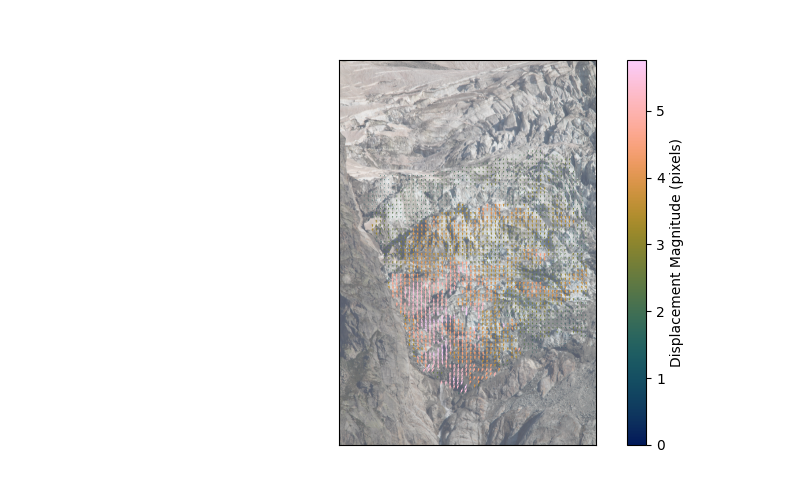

In [50]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_dic_vectors(
    x=df["x"].to_numpy(),
    y=df["y"].to_numpy(),
    u=df["u"].to_numpy(),
    v=df["v"].to_numpy(),
    magnitudes=df["V"].to_numpy(),
    background_image=img,
    cmap_name="batlow",
    # vmin=0.1,
    # vmax=10,
    fig=fig,
    ax=ax,
)
fig.savefig(output_dir / f"{base_name}_dic.png", dpi=300, bbox_inches="tight")

In [40]:
# Define some sectors with prior information on clusters and use them in the  GMM clustering

import glob

import numpy as np

from src.roi import PolygonROISelector

# Load all sector polygons
sector_files = sorted(glob.glob("data/sectors_prior/*.json"))
sector_selectors = [PolygonROISelector.from_file(f) for f in sector_files]


# Assign prior class to each row
def assign_prior_class(df, selectors):
    prior_class = np.full(len(df), -1, dtype=int)
    for idx, selector in enumerate(selectors):
        mask = selector.contains_points(df["x"].values, df["y"].values)
        prior_class[mask] = idx
    return prior_class


df["prior_class"] = assign_prior_class(df, sector_selectors)
df

,x,y,u,v,V,prior_class
0,256,1856,0.236667,1.105000,1.130060,-1
1,320,1856,0.238333,1.101667,1.127152,-1
2,384,1856,0.240000,1.098333,1.124249,-1
3,384,2112,0.421667,1.325000,1.390478,3
4,384,2240,0.188333,1.325000,1.338318,3
...,...,...,...,...,...,...
2065,3840,3584,0.293333,3.151667,3.165288,-1
2066,3840,3712,-0.293333,1.955000,1.976884,-1
2067,3840,3840,-0.548333,1.991667,2.065770,-1
2068,3840,3968,-0.508333,1.596667,1.675633,-1


Variational Bayesian Gaussian Mixture


/home/francesco/ppcx/ppcx-domains/.venv/lib/python3.13/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


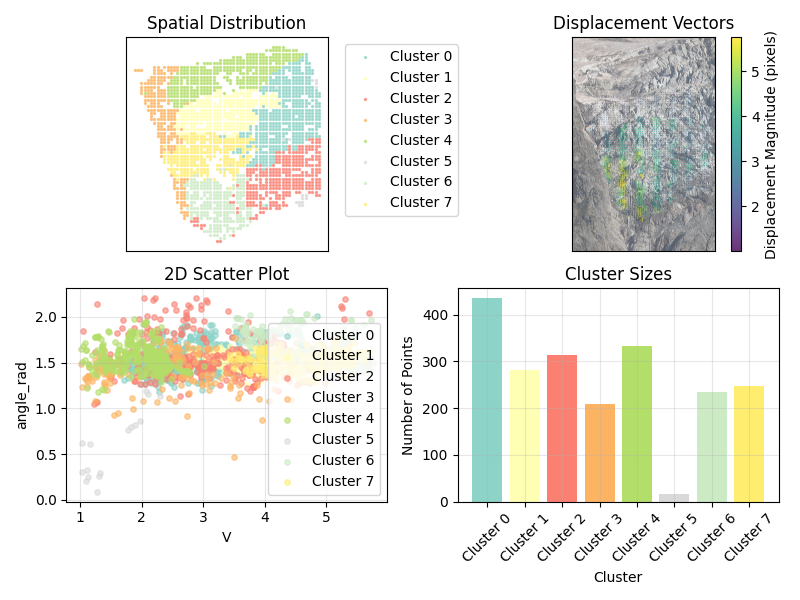

In [51]:
# Get parameters for GMM clustering

# 3. Add 'prior_class' to features for clustering
variables_names = config.get("clustering.variables_names")
n_components = config.get("clustering.n_components")
weight_concentration_prior = config.get("clustering.weight_concentration_prior")
covariance_type = config.get("clustering.covariance_type")

# Extract features and standardize them
df_features = preproc_features(df)
features = df_features[variables_names].values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


gmm = BayesianGaussianMixture(
    n_components=n_components,
    weight_concentration_prior=weight_concentration_prior,
    covariance_type=covariance_type,
    max_iter=config.get("clustering.max_iter"),
    random_state=config.get("clustering.random_state"),
)
gmm.fit(features_scaled)
labels = gmm.predict(features_scaled)


fig, ax, stats_df = plot_gmm_clusters(
    df_features,
    labels,
    var_names=["V", "angle_rad"],
    img=img,
    figsize=(8, 6),
)
fig.savefig(output_dir / f"{base_name}_clusters.png", dpi=300, bbox_inches="tight")

# Save the GMM model
joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")
gmm_run_name = f"{base_name}_GMM_comp{n_components}_cov{covariance_type}_wcp{weight_concentration_prior}"
joblib.dump(gmm, output_dir / f"{gmm_run_name}.joblib")

# Save the features DataFrame with labels
df_features.to_csv(output_dir / f"{base_name}_features_with_labels.csv", index=False)

In [43]:
plot_gmm_log_likelihood_contours(
    df_features, gmm, scaler, variables_names, pair=("V", "angle_rad")
)

ConfigValueError: Item not found in ListConfig
    full_key: clustering.variables_names
    object_type=list

In [ ]:
# # --- Post-process clustering ---
# min_cluster_size = 30
# smoothing_window_size = 10
# labels_clean = remove_small_clusters(labels, min_size=min_cluster_size)
# labels_smooth = spatial_smooth_labels(
#     df_features, labels_clean, window_size=smoothing_window_size
# )
# labels_smooth = merge_similar_clusters(df_features, labels_smooth, threshold=10)

# # Plot results after cleaning and smoothing
# plot_gmm_clusters(
#     df_features,
#     labels_smooth,
#     var_names=["V", "angle_rad"],
#     img=img,
#     figsize=(8, 6),
# )
